### 数据加载与探索

特征名称: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
类别名称: ['setosa' 'versicolor' 'virginica']
样本数: 150 特征数: 4
标签分布:
 0    50
1    50
2    50
Name: count, dtype: int64


D:\anaconda\envs\rurie\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 40482 (\N{CJK UNIFIED IDEOGRAPH-9E22}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda\envs\rurie\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23614 (\N{CJK UNIFIED IDEOGRAPH-5C3E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda\envs\rurie\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 33457 (\N{CJK UNIFIED IDEOGRAPH-82B1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda\envs\rurie\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda\envs\rurie\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25454 (\N{CJK UNIFIED IDEOGRAPH-636E}) missing from font(s) DejaVu Sans.
  fig.c

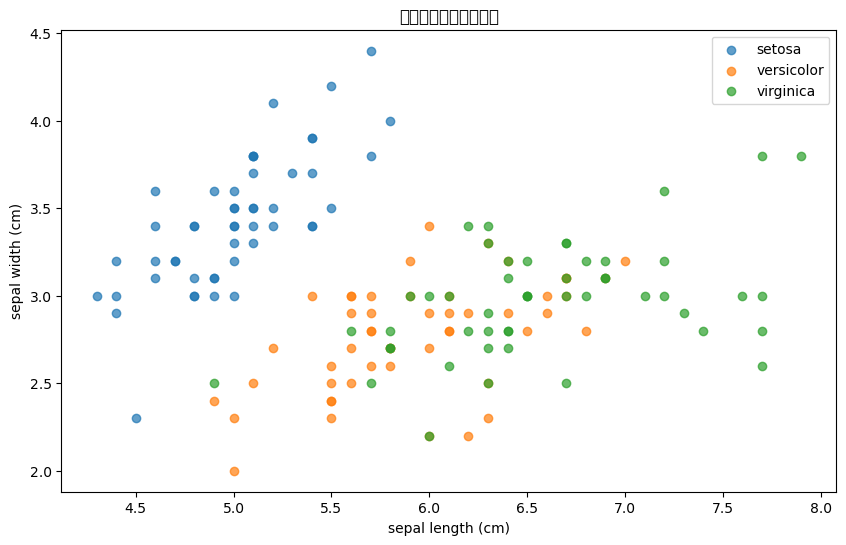

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

# 加载数据集
data = load_iris()
X = data.data # 提取特征数组
y = data.target # 提取标签数组
feature_names = data.feature_names # 特征名数组
target_names = data.target_names # 标签名数组

# 查看数据基本信息
print("特征名称:", feature_names)
print("类别名称:", target_names)
print("样本数:", X.shape[0], "特征数:", X.shape[1])
print("标签分布:\n", pd.Series(y).value_counts())

# 可视化前两个特征的分布
plt.figure(figsize=(10, 6))
# 以特征进行描点，以标签进行上色
for i, class_name in enumerate(target_names):
    plt.scatter(X[y == i, 0], X[y == i, 1], label=class_name, alpha=0.7) # 利用布尔数组来提取三个标签的样本中前两个特征的分布
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.title("鸢尾花数据集特征分布")
plt.legend()
plt.show()


### 数据预处理


In [4]:
# 划分数据集和测试集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("训练集维度:", X.shape)
print("测试集维度:", y.shape)

训练集维度: (150, 4)
测试集维度: (150,)


### 手动实现决策树（简化版）

In [5]:
class DecisionTreeManual:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth # 树的最大深度
        self.tree = {} # 树结构用字典来表示
        
    def _gini(self, y):
        """计算基尼不纯度（Gini Impurify）"""
        classes = np.unique(y) # 获取分类类别
        gini = 1.0
        for cls in classes:
            p = np.sum(y == cls) / len(y)
            gini -= p ** 2
        return gini
    
    # 最小化加权gini指数来使数据更加纯净
    def _best_split(self, X, y):
        """寻找最佳的分割特征和分割点"""
        best_gini = float('inf') # 初始化最优gini系数为无穷大
        best_feature = None # 最佳特征索引
        best_value = None # 最优分割点
        
        """嵌套循环找到最佳特征下的最佳分割点"""
        # 遍历所有特征寻找最佳分割点
        for feature_idx in range(X.shape[1]):
            # 获取唯一值作为候选分割点
            unique_values = np.unique(X[:, feature_idx])
            for value in unique_values:
                # 分为左右子集
                left_mask = X[:, feature_idx] <= value
                right_mask = ~left_mask # X[feature_idx] > value 
                # 达到分割目标就跳过
                if len(y[left_mask]) == 0 or len(y[right_mask]) == 0:
                    continue
                
                # 计算加权gini不纯度
                gini_left = self._gini(y[left_mask])
                gini_right = self._gini(y[right_mask])
                total_gini = (len(y[left_mask]) * gini_left + len(y[right_mask]) * gini_right) / len(y)
                
                if total_gini < best_gini:
                    best_gini = total_gini
                    best_feature = feature_idx
                    best_value = value
        return best_feature, best_value
    
    def _build_tree(self, X, y, depth=0):
        """递归构建决策树"""
        # 终止条件：决策树纯度达到100%或者达到最大深度
        if len(np.unique(y)) == 1 or (self.max_depth is not None and depth >= self.max_depth):
            return {'class':np.argmax(np.bincount(y))}
            # bincount返回y中的元素个数数组，这段代码是分割完后进行选择最多的标签进行返回
        
        # 寻找最佳分割
        feature_idx, value = self._best_split(X, y)
        if feature_idx is None: # 无法进一步分割
            return {'class':np.argmax(np.bincount(y))}
        
        # 分割数据
        left_mask = X[:, feature_idx] <= value
        right_mask = ~left_mask
        
        # 递归构建左右子树
        left = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        
        """返回每一层的信息"""
        return {
            'feature_idx': feature_idx,
            'value': value, 
            'left': left,
            'right': right
        }
    
    def fit(self, X, y):
        """训练模型"""
        self.tree = self._build_tree(X, y)
        
    def _predict_sample(self, sample, tree):
        """预测单个样本"""
        if 'class' in tree:
            return tree['class'] # 如果树中包含'class'则该节点为叶节点可直接返回class的值也就是标签
        if sample[tree['feature_idx']] <= tree['value']: 
            return self._predict_sample(sample, tree['left']) # 如果 sample[tree['feature_idx']] <= tree['value']，进入左子树
        else:
            return self._predict_sample(sample, tree['right']) # 否则，进入右子树
        
    def predict(self, X):
        """批量预测"""
        return np.array([self._predict_sample(x, self.tree) for x in X]) # 将单个预测组成数组

# 训练手动实现的模型（限制最大深度为3）
manual_model = DecisionTreeManual(max_depth = 3) # max_depth是一个超参数
manual_model.fit(X_train, y_train)

# 预测测试集
y_pred_manual = manual_model.predict(X_test)

### sklearn实现

D:\anaconda\envs\rurie\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20915 (\N{CJK UNIFIED IDEOGRAPH-51B3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda\envs\rurie\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 31574 (\N{CJK UNIFIED IDEOGRAPH-7B56}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda\envs\rurie\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26641 (\N{CJK UNIFIED IDEOGRAPH-6811}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda\envs\rurie\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32467 (\N{CJK UNIFIED IDEOGRAPH-7ED3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda\envs\rurie\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26500 (\N{CJK UNIFIED IDEOGRAPH-6784}) missing from font(s) DejaVu Sans.
  fig.c

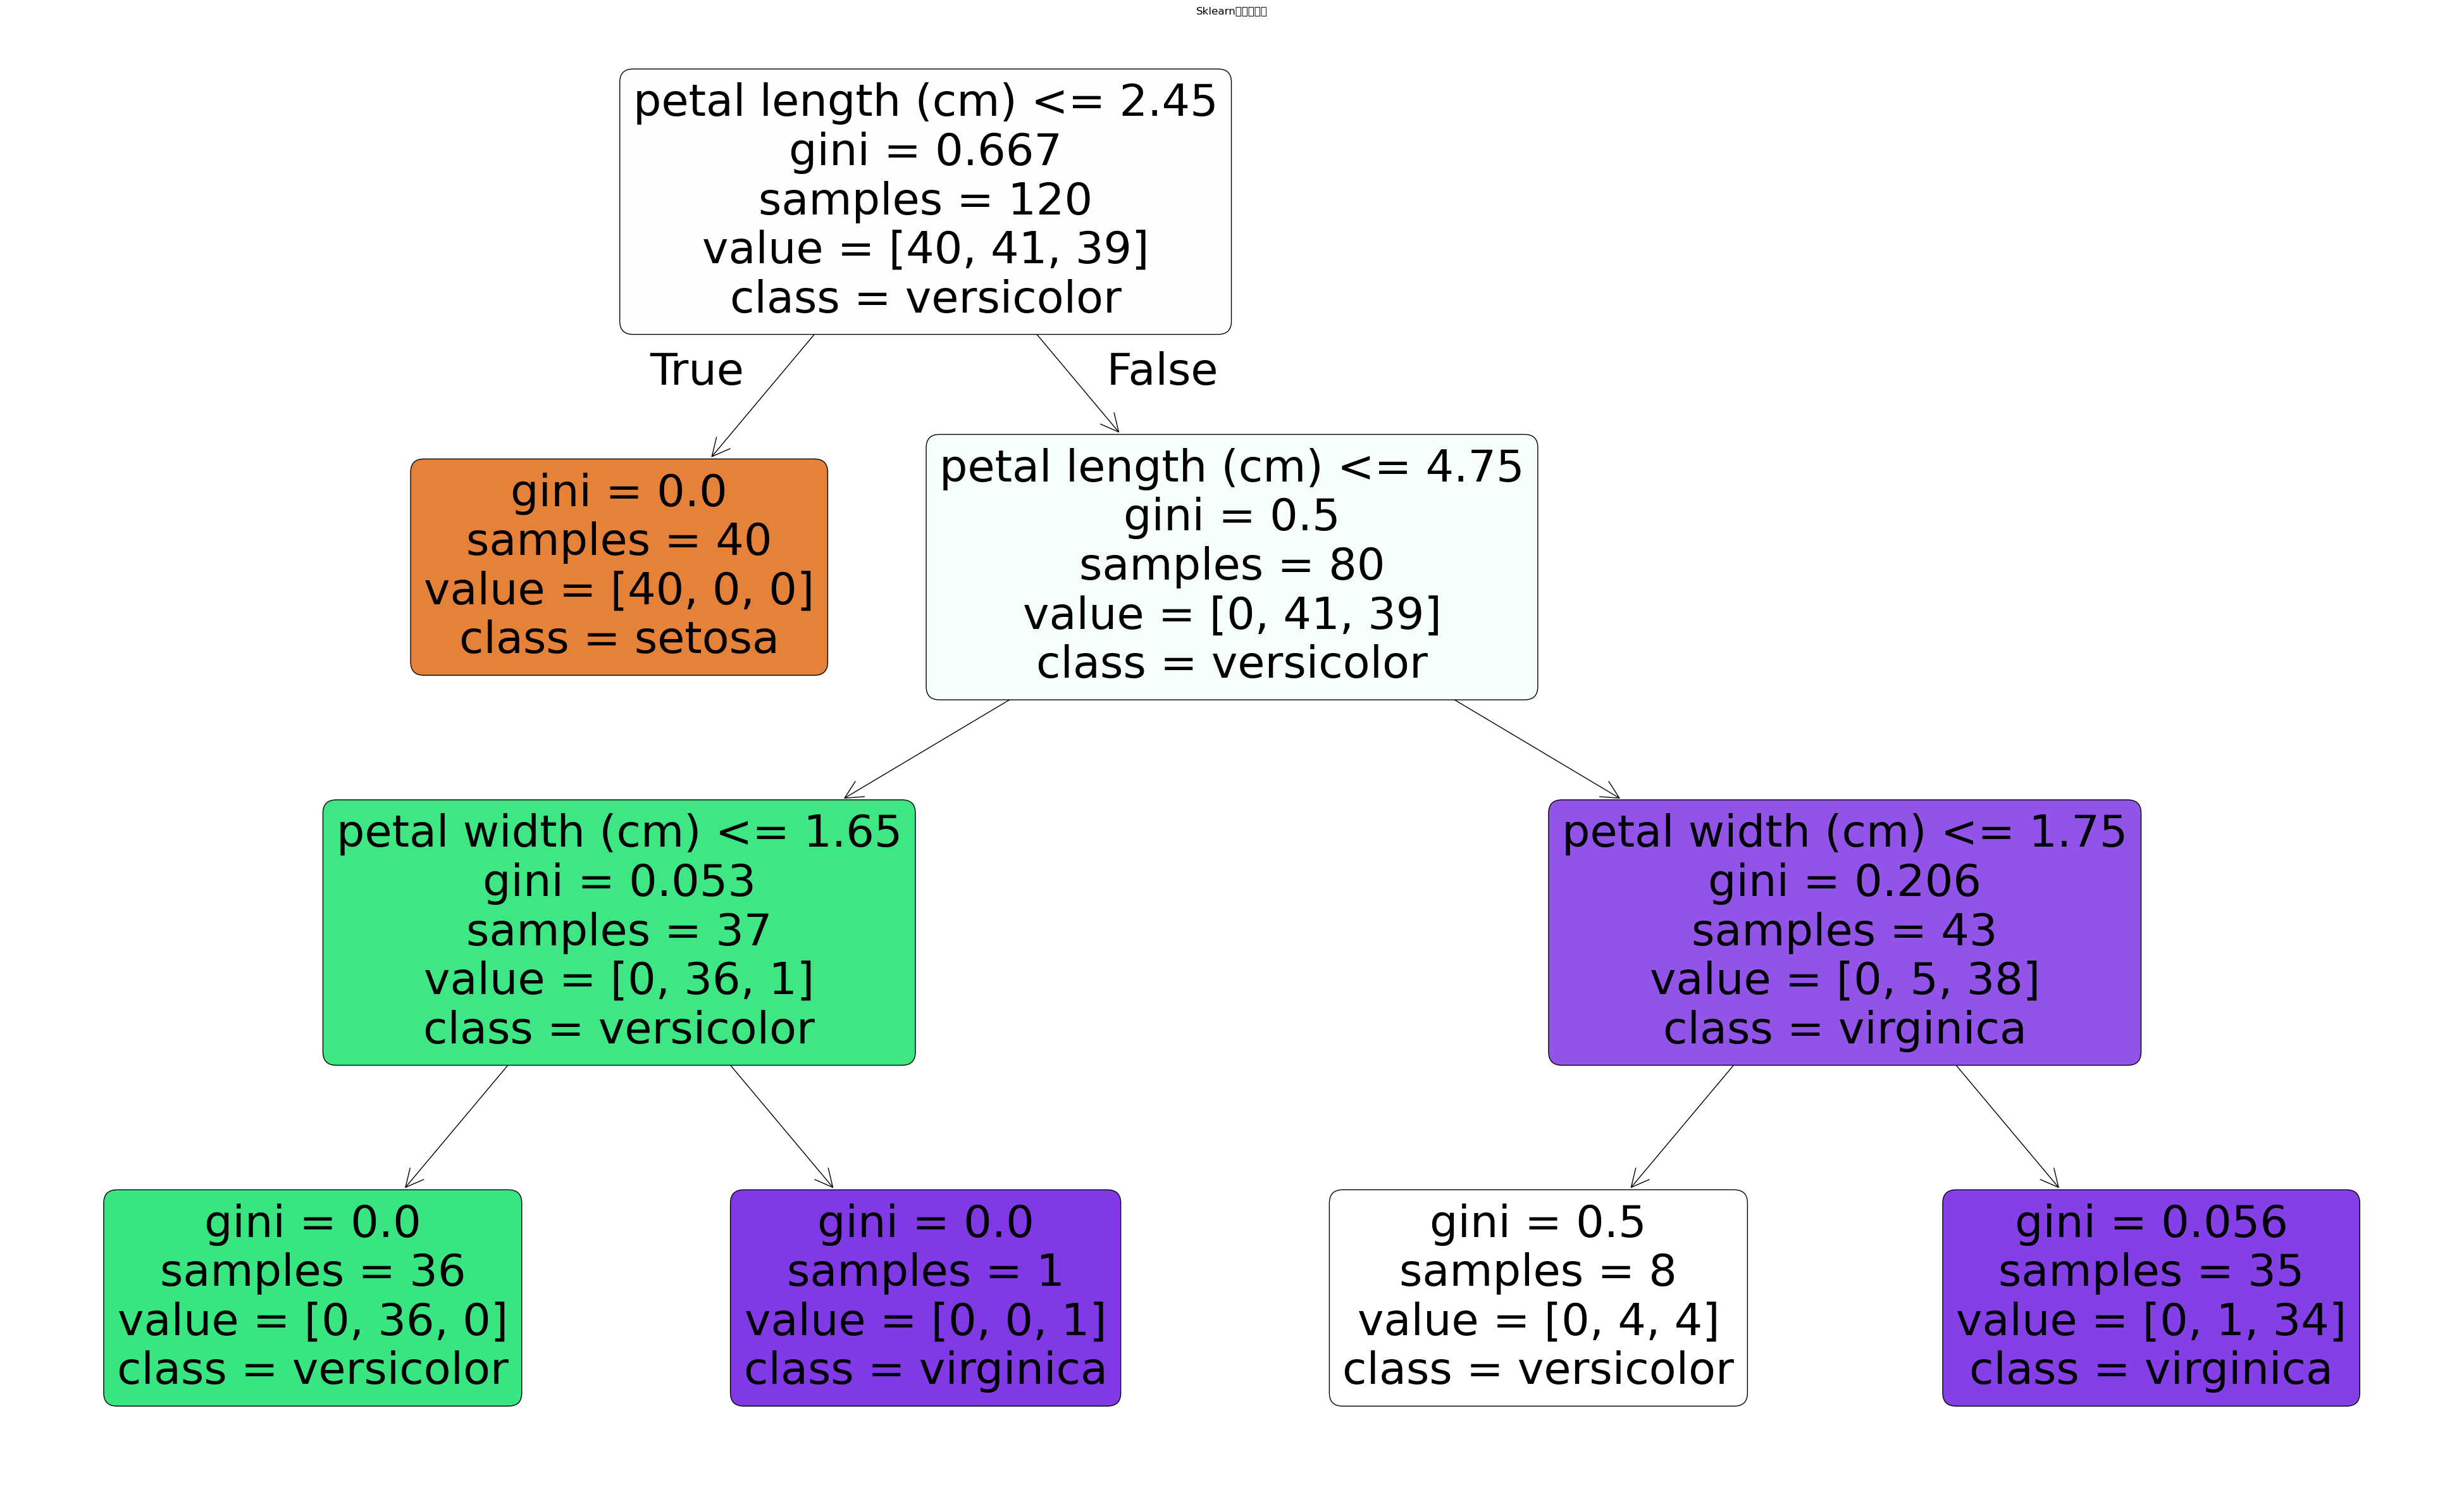

In [7]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
# 创建并训练模型
sklearn_model = DecisionTreeClassifier(max_depth=3, random_state=42)
sklearn_model.fit(X_train, y_train)

# 预测测试集
y_pred_sklearn = sklearn_model.predict(X_test)

# 可视化决策树
plt.figure(figsize=(50, 30))
plot_tree(sklearn_model,
         feature_names=feature_names,
         class_names=target_names,
         filled=True,
         rounded=True)
plt.title("Sklearn决策树结构")
plt.show()

### 模型评估与对比

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
def evaluate_model(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=target_names)
    
    print(f"\n[{model_name}] 准确率: {acc:.3f}")
    print(f"[{model_name}] 混淆矩阵:", cm)
    print(f"[{model_name}] 分类报告:", report)
    
# 对比两个模型
evaluate_model(y_test, y_pred_manual, "手动实现决策树")
evaluate_model(y_test, y_pred_sklearn, "sklearn决策树")


[手动实现决策树] 准确率: 1.000
[手动实现决策树] 混淆矩阵: [[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]
[手动实现决策树] 分类报告:               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


[sklearn决策树] 准确率: 1.000
[sklearn决策树] 混淆矩阵: [[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]
[sklearn决策树] 分类报告:               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

